# Exploratory Data Analysis and Modeling

This project is to implement the exploratory analysis plan for Analysing 911 calls assigned to San Francisco Fire Department (SFFD).

Data of Calls to SFFD has been downloaded from https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3 . A subset of data from Dec 31, 2016 to January 7, 2017 is used for Analysis here.

> ### Hypothesis

Location and time of the day will help in measuring the call traffic on the Battalions of San Francisco Fire Department

In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model, cross_validation, preprocessing, neighbors, grid_search, metrics

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

> ### Read Dataset

In [2]:
df = pd.read_csv('Fire_Department_Calls_for_Service.csv')

In [3]:
df.head()

,Call Number,Unit ID,Incident Number,Call Type,Call Date,...,Fire Prevention District,Supervisor District,Neighborhood District,Location,RowID
0,163664050,E39,16146990,Citizen Assist / Service Call,12/31/2016,...,8,7,West of Twin Peaks,"(37.745858648581, -122.456664252061)",163664050-E39
1,163664036,E38,16146989,Medical Incident,12/31/2016,...,4,2,Marina,"(37.8051625655624, -122.432957440518)",163664036-E38
2,163664036,AM30,16146989,Medical Incident,12/31/2016,...,4,2,Marina,"(37.8051625655624, -122.432957440518)",163664036-AM30
3,163664020,E10,16146988,Outside Fire,12/31/2016,...,4,2,Pacific Heights,"(37.7885701888359, -122.44394001715)",163664020-E10
4,163664007,KM204,16146987,Medical Incident,12/31/2016,...,2,9,Mission,"(37.7643732096664, -122.417478491468)",163664007-KM204


> ### Number of Observations 

In [4]:
df.shape

(7704, 34)

> ### Exploring the features in the Dataset

A description of the dataset is as follows:

- Call Number: A unique 9-digit number assigned by the 911 Dispatch Center (DEM) to this call. These number are used for both Police and Fire calls.

- Unit ID 

- Incident Number: A unique 8-digit number assigned by DEM to this Fire incident.

- Call Type

- Call Date: Date the call is received at the 911 Dispatch Center.

- Watch Date: Watch date when the call is received. Watch date starts at 0800 each morning and ends at 0800 the next day.

- Received DtTm: Date and time of call is received at the 911 Dispatch Center.

- Entry DtTm: Date and time the 911 operator submits the entry of the initical call information into the CAD system

- Dispatch DtTm: Date and time the 911 operator dispatches this unit to the call.

- Response DtTm: Date and time this unit acknowledges the dispatch and records that the unit is en route to the location of the call.

- On Scene DtTm: Date and time the unit records arriving to the location of the incident

- Transport DtTm: If this unit is an ambulance, date and time the unit begins the transport unit arrives to hospital

- Hospital DtTm: If this unit is an ambulance, date and time the unit arrives to the hospital.

- Call Final Disposition: Disposition of the call (Code). For example TH2: Transport to Hospital  Code 2, FIR: Resolved by Fire Department

- Available DtTm: Date and time this unit is not longer assigned to this call and it is available for another dispatch.

- Address: Address of incident (note: address and location generalized to mid-block of street, intersection or nearest call box location, to protect caller privacy).

- City

- Zipcode of Incident

- Battalion: Emergency Response District (There are 9 Fire Emergency Response Districts)

- Station Area: Fire Station First Response Area associated with the address of the incident

- Box: Fire box associated with the address of the incident. A box is the smallest area used to divide the City. Each box is associated with a unique unit dispatch order. The City is divided into more than 2,400 boxes.

- Original Priority: Initial call priority (Code 2: Non-Emergency or Code 3:Emergency).

- Priority: Call priority (Code 2: Non-Emergency or Code 3:Emergency).

- Final Priority: Final call priority (Code 2: Non-Emergency or Code 3:Emergency).

- ALS Unit: Does this unit includes ALS (Advance Life Support) resources? Is there a paramedic in this unit?

- Call Type Group: Call types are divided into four main groups: Fire, Alarm, Potential Life Threatening and Non Life Threatening.

- Number of Alarms: Number of alarms associated with the incident. This is a number between 1 and 5.

- Unit Type: A number that indicates the order this unit was assigned to this call

- Unit sequence in call dispatch

- Fire Prevention District: Bureau of Fire Prevention District associated with this address

- Supervisor District: Supervisor District associated with this address (note: these are the districts created in 2012).

- Neighborhood  District: Neighborhood District associated with this address

- Location: Location of incident (note: address and location generalized to mid-block of street, intersection or nearest call box location, to protect caller privacy).

- RowID: Unique Call Number and Unit ID combination

In [6]:
with pd.option_context('display.max_rows', 999):
    print(df.dtypes)

Call Number                         int64
Unit ID                            object
Incident Number                     int64
Call Type                          object
Call Date                          object
Watch Date                         object
Received DtTm                      object
Entry DtTm                         object
Dispatch DtTm                      object
Response DtTm                      object
On Scene DtTm                      object
Transport DtTm                     object
Hospital DtTm                      object
Call Final Disposition             object
Available DtTm                     object
Address                            object
City                               object
Zipcode of Incident               float64
Battalion                          object
Station Area                      float64
Box                                 int64
Original Priority                  object
Priority                           object
Final Priority                    

> ### Creating a summary table.

In [7]:
df.describe()

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Call Number,Incident Number,Zipcode of Incident,Station Area,Box,Final Priority,Number of Alarms,Unit sequence in call dispatch
count,7.704000e+03,7.704000e+03,7700.000000,7701.000000,7704.000000,7704.000000,7704.000000,7704.000000
mean,1.693360e+08,1.690712e+07,94113.040000,18.159590,4023.344367,2.701584,1.002985,2.083463
std,2.001008e+06,2.681311e+05,10.173222,14.720843,2325.432036,0.457593,0.054561,1.816641
min,1.636600e+08,1.614656e+07,94102.000000,1.000000,231.000000,2.000000,1.000000,1.000000
25%,1.700138e+08,1.700051e+07,NaN,NaN,2123.000000,2.000000,1.000000,1.000000
50%,1.700403e+08,1.700146e+07,NaN,NaN,3412.000000,3.000000,1.000000,2.000000
75%,1.700541e+08,1.700234e+07,NaN,NaN,5728.000000,3.000000,1.000000,2.000000
max,1.700736e+08,1.700330e+07,94158.000000,51.000000,9944.000000,3.000000,2.000000,23.000000


> ### Data points will null data

In [8]:
with pd.option_context('display.max_rows', 999):
    print(df.isnull().sum())

Call Number                          0
Unit ID                              0
Incident Number                      0
Call Type                            0
Call Date                            0
Watch Date                           0
Received DtTm                        0
Entry DtTm                           0
Dispatch DtTm                        0
Response DtTm                      214
On Scene DtTm                     1554
Transport DtTm                    5441
Hospital DtTm                     5496
Call Final Disposition               0
Available DtTm                       5
Address                              0
City                                14
Zipcode of Incident                  4
Battalion                            0
Station Area                         3
Box                                  0
Original Priority                    0
Priority                             0
Final Priority                       0
ALS Unit                             0
Call Type Group          

> ### Plotting the frequency of Battalions

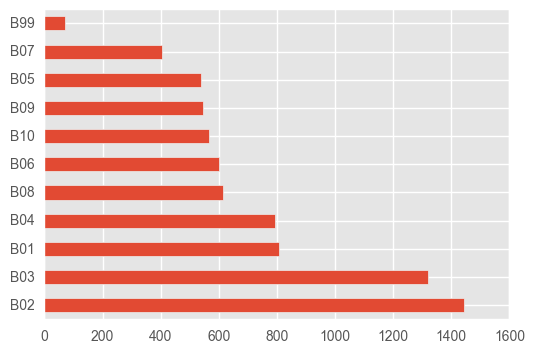

In [9]:
df['Battalion'].value_counts(dropna = False).plot(kind='barh')

> ### Plotting the frequency of the type of calls

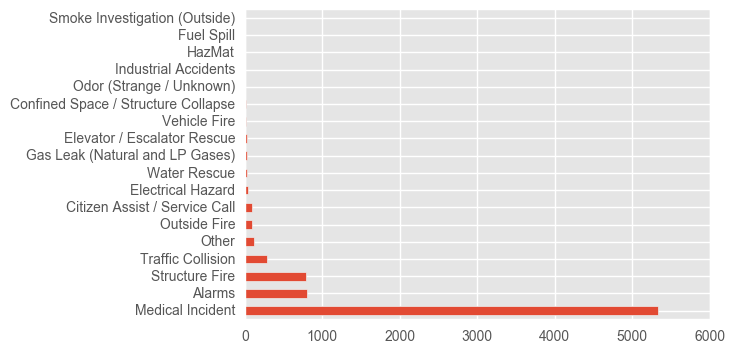

In [10]:
df['Call Type'].value_counts(dropna = False).plot(kind='barh')

> ### Plotting the call frequency at various Neighborhoods

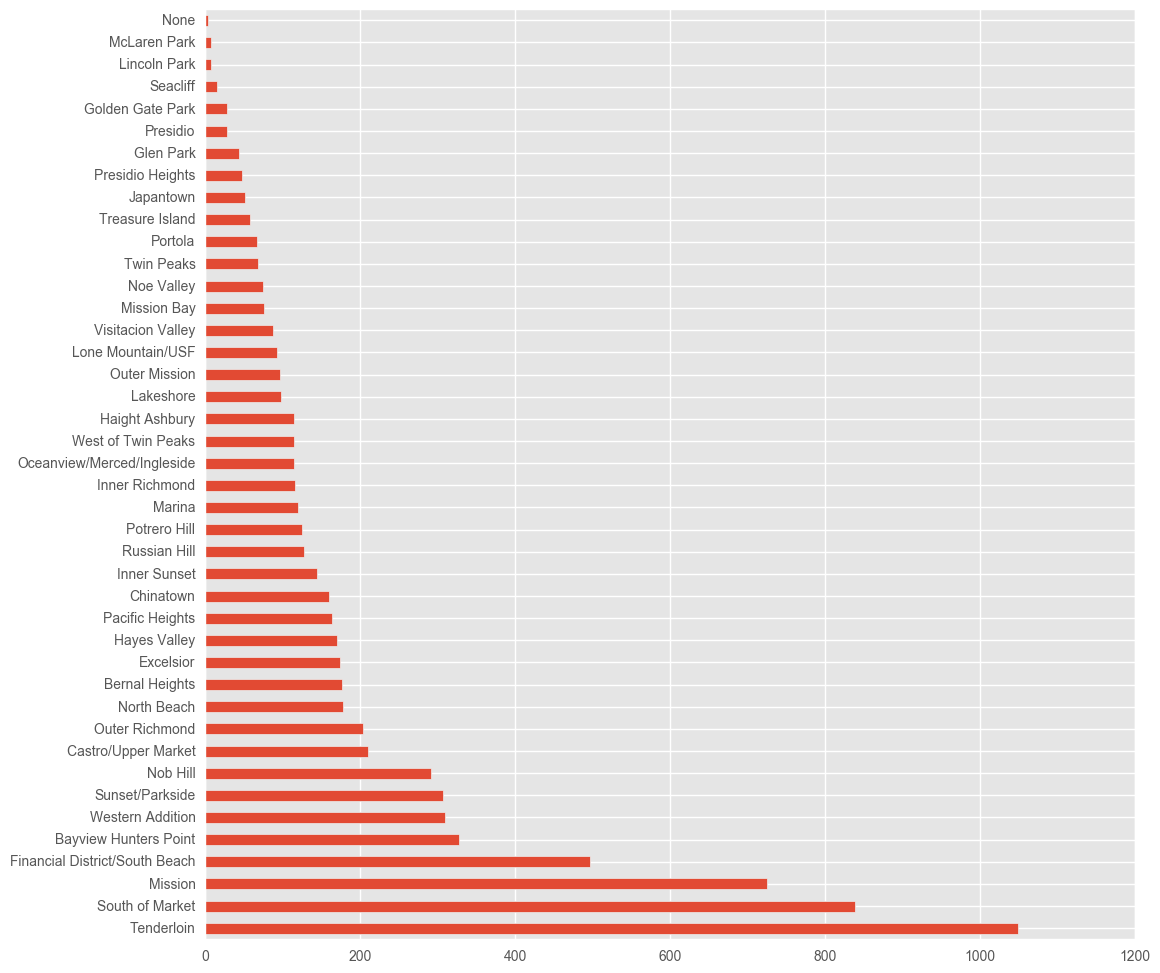

In [11]:
df['Neighborhood  District'].value_counts(dropna = False).plot(kind='barh', figsize = (12,12))

> ### Plotting distributions for numeric features

In [12]:
df.dtypes.value_counts()

object     25
int64       6
float64     2
bool        1
dtype: int64

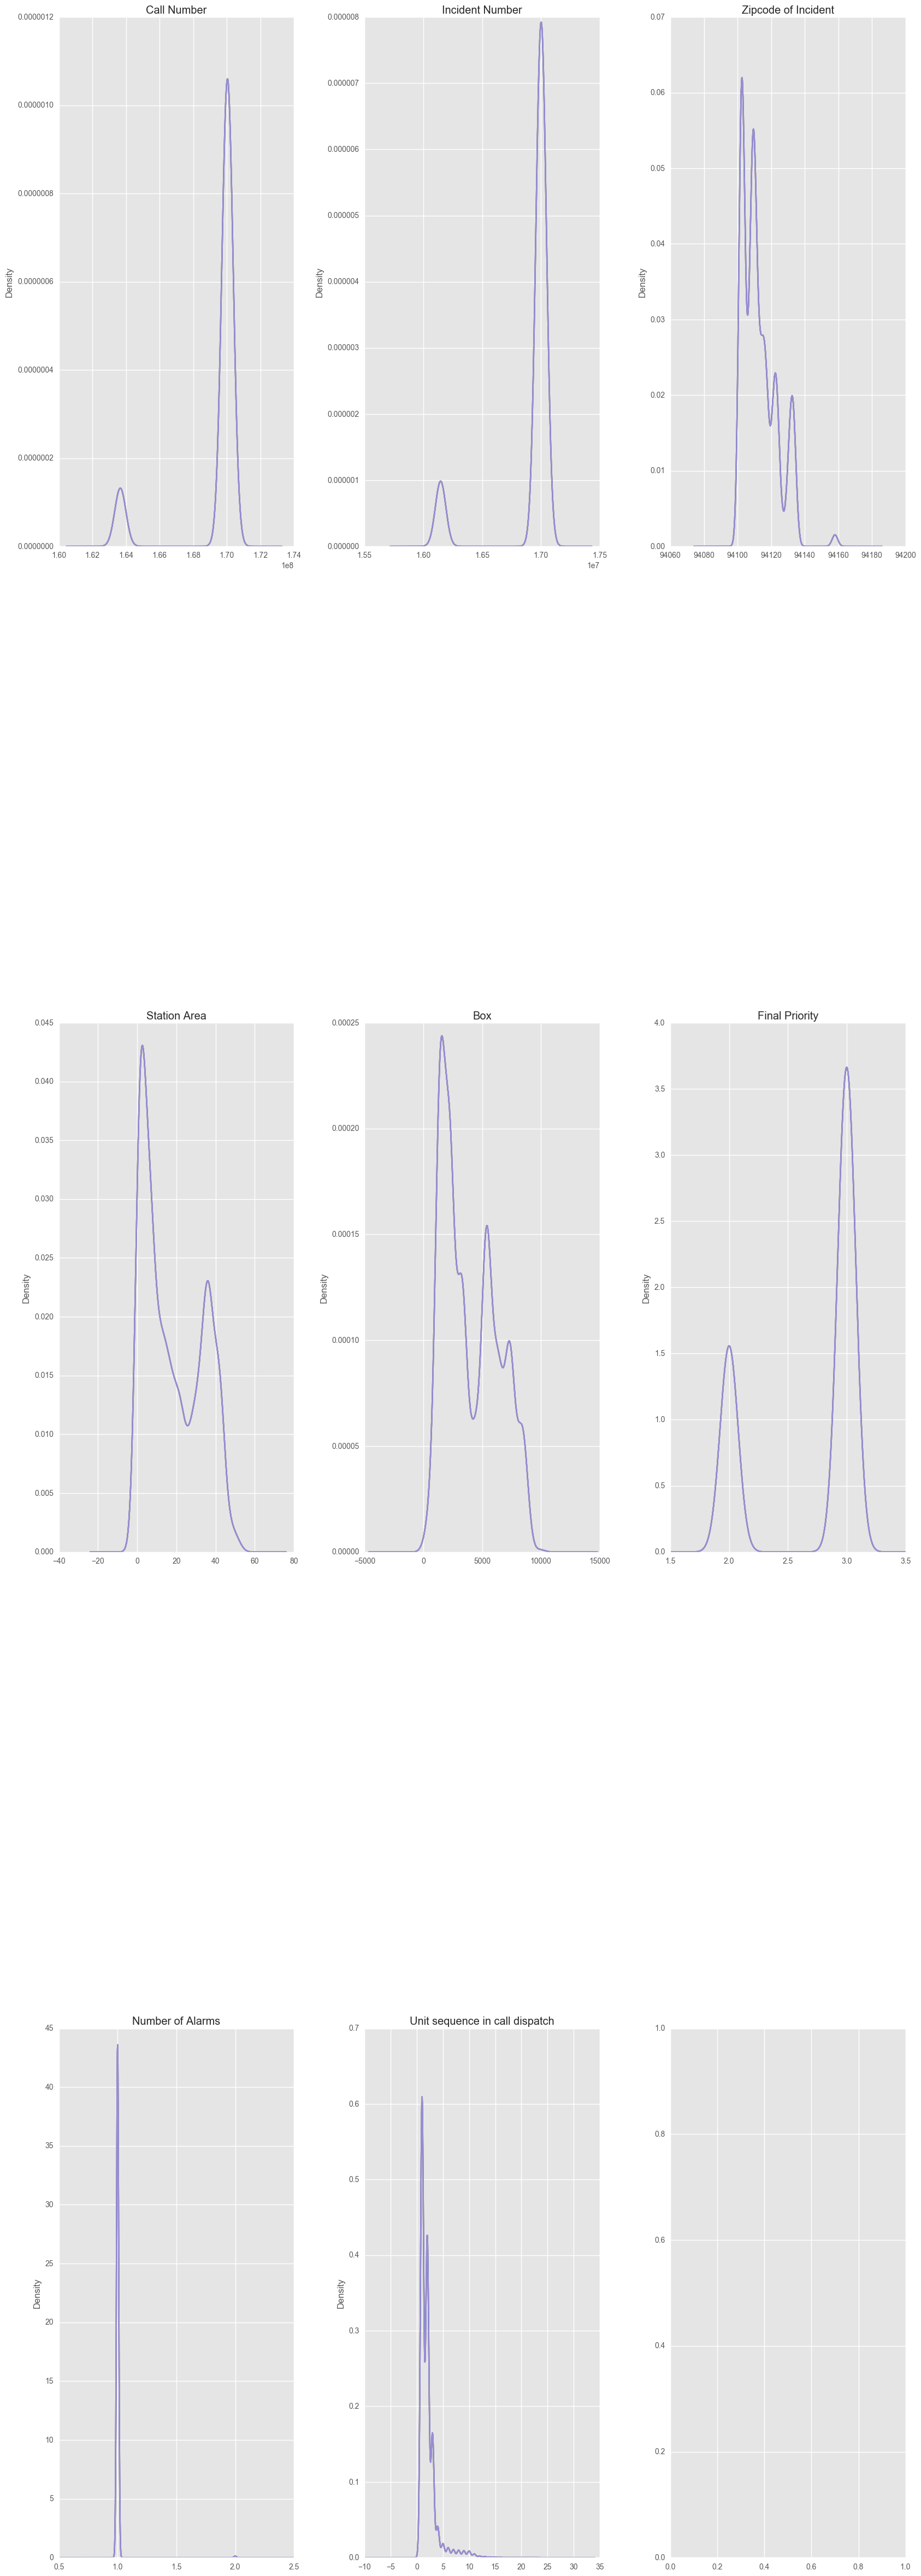

In [13]:
num_df = df.select_dtypes(include=['float64','int64'])
n_cols = 3
n_rows = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize = (20,60))

fig.subplots_adjust(hspace=.9, wspace=.3)

for k in axs:
    for i,j in zip(num_df, axs.flat):
        g = num_df[i].plot.kde(ax = j, title = i)

> ### Correlation Matrix of the dataset

In [15]:
df.corr()

,Call Number,Incident Number,Zipcode of Incident,Station Area,Box,Final Priority,ALS Unit,Number of Alarms,Unit sequence in call dispatch
Call Number,1.000000,0.999981,0.004991,0.007525,-0.001754,0.051479,-0.003768,0.019545,0.026479
Incident Number,0.999981,1.000000,0.004963,0.007472,-0.001807,0.051395,-0.003680,0.019364,0.026177
Zipcode of Incident,0.004991,0.004963,1.000000,0.300403,0.462290,0.021229,-0.026341,0.096637,0.080030
Station Area,0.007525,0.007472,0.300403,1.000000,0.341518,0.018793,-0.032630,0.006843,0.043216
Box,-0.001754,-0.001807,0.462290,0.341518,1.000000,-0.006347,0.033828,0.031620,-0.005807
Final Priority,0.051479,0.051395,0.021229,0.018793,-0.006347,1.000000,-0.124573,0.035688,0.224395
ALS Unit,-0.003768,-0.003680,-0.026341,-0.032630,0.033828,-0.124573,1.000000,-0.040325,-0.190716
Number of Alarms,0.019545,0.019364,0.096637,0.006843,0.031620,0.035688,-0.040325,1.000000,0.298727
Unit sequence in call dispatch,0.026479,0.026177,0.080030,0.043216,-0.005807,0.224395,-0.190716,0.298727,1.000000


> ### Linear Regression Model for features Box and Battaion

In [21]:
# Create a set of dummy variables from the Battalion variable
df_Battalion = pd.get_dummies(df['Battalion'])

In [22]:
df_new = df.join(df_Battalion)

In [23]:
df_new.columns

Index(['Call Number', 'Unit ID', 'Incident Number', 'Call Type', 'Call Date',
       'Watch Date', 'Received DtTm', 'Entry DtTm', 'Dispatch DtTm',
       'Response DtTm', 'On Scene DtTm', 'Transport DtTm', 'Hospital DtTm',
       'Call Final Disposition', 'Available DtTm', 'Address', 'City',
       'Zipcode of Incident', 'Battalion', 'Station Area', 'Box',
       'Original Priority', 'Priority', 'Final Priority', 'ALS Unit',
       'Call Type Group', 'Number of Alarms', 'Unit Type',
       'Unit sequence in call dispatch', 'Fire Prevention District',
       'Supervisor District', 'Neighborhood  District', 'Location', 'RowID',
       'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10',
       'B99'],
      dtype='object')

In [24]:
X = df_new[[      
        'B01', 
        'B02', 
        'B03', 
        'B04', 
        'B05', 
        'B06', 
        'B07', 
        'B08', 
        'B09', 
        'B10',
        'B99'
    ]]

y = df_new['Box']
       
model = linear_model.LinearRegression()
model.fit(X,y)

print(model.intercept_)
print(model.coef_)

3.81671588699e+13
[ -3.81671589e+13  -3.81671589e+13  -3.81671589e+13  -3.81671589e+13
  -3.81671589e+13  -3.81671589e+13  -3.81671589e+13  -3.81671589e+13
  -3.81671589e+13  -3.81671589e+13  -3.81671589e+13]


In [25]:
model.score(X, y)

0.75490347821167647

# GeoCoding

In [36]:
from pygeocoder import Geocoder,GeocoderError

In [33]:
import time

In [40]:
# Verify if address is valid in Google's system
lat = []
long = []
for row in df:
    if row['Call Type'] == "Structure Fire":
        try:
            results  = Geocoder.geocode(row['Address'])
            (lat, long) = results.coordinates
            time.sleep(1)
        except GeocoderError:
            (lat, long) = (0.0, 0.0)

TypeError: string indices must be integers

In [81]:
call_zipcode=df.loc(df['Zipcode of Incident'])

In [87]:
type(call_zipcode)

pandas.core.indexing._LocIndexer

Shape file source : https://github.com/sfroid/sfcoord2nbh/tree/master/sffind_neighborhoods

In [70]:
from mpl_toolkits.basemap import Basemap
import fiona
from shapely.geometry import shape, mapping
from pyproj import Proj, transform
from itertools import chain
from fiona.crs import from_epsg
import geopandas as gp

shapefile="/Users/nikita/Documents/DS-SF-30/final-project/datasets/sf_neighborhoods/SFFind_Neighborhoods.shp"
shp = fiona.open(shapefile)
bds = shp.bounds
print (bds)

shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

(-122.5148972319999, 37.708089209000036, -122.35698198799994, 37.83239597600004)


In [113]:
neighborhoods = gp.GeoDataFrame.from_file(
    '/Users/nikita/Documents/DS-SF-30/final-project/datasets/sf_neighborhoods/SFFind_Neighborhoods.shp')
neighborhoods.head()

,LINK,geometry,name
0,"http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...",POLYGON ((-122.4934552679999 37.78351817100008...,Seacliff
1,None,POLYGON ((-122.4871507149999 37.78378542700005...,Lake Street
2,http://www.nps.gov/prsf/index.htm,POLYGON ((-122.4775801709999 37.81099311300005...,Presidio National Park
3,None,POLYGON ((-122.4724105299999 37.78734653900005...,Presidio Terrace
4,http://www.sfgate.com/neighborhoods/sf/innerri...,POLYGON ((-122.4726257899999 37.78631480600006...,Inner Richmond


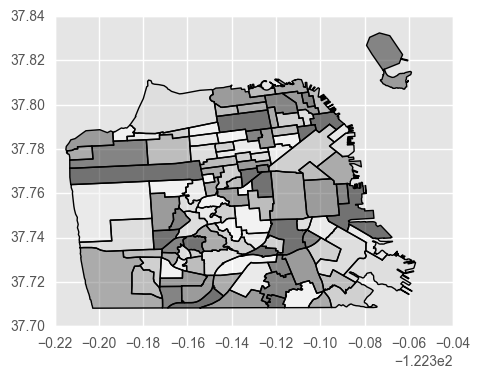

In [114]:
neighborhoods.plot()

(117,
 5,
 [-122.5148972319999, 37.708089209000036, 0.0, 0.0],
 [-122.35698198799994, 37.83239597600004, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x11a9972b0>)

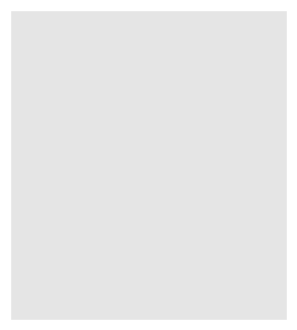

In [106]:
m = Basemap(
    projection='tmerc',
    lon_0=-122.,
    lat_0=37.7,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    '/Users/nikita/Documents/DS-SF-30/final-project/datasets/sf_neighborhoods/SFFind_Neighborhoods',
    'SF',
    color='none',
    zorder=2)

In [75]:
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from matplotlib.collections import PatchCollection

# Set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.SF],'ward_name': [ward['name'] for ward in m.SF_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000


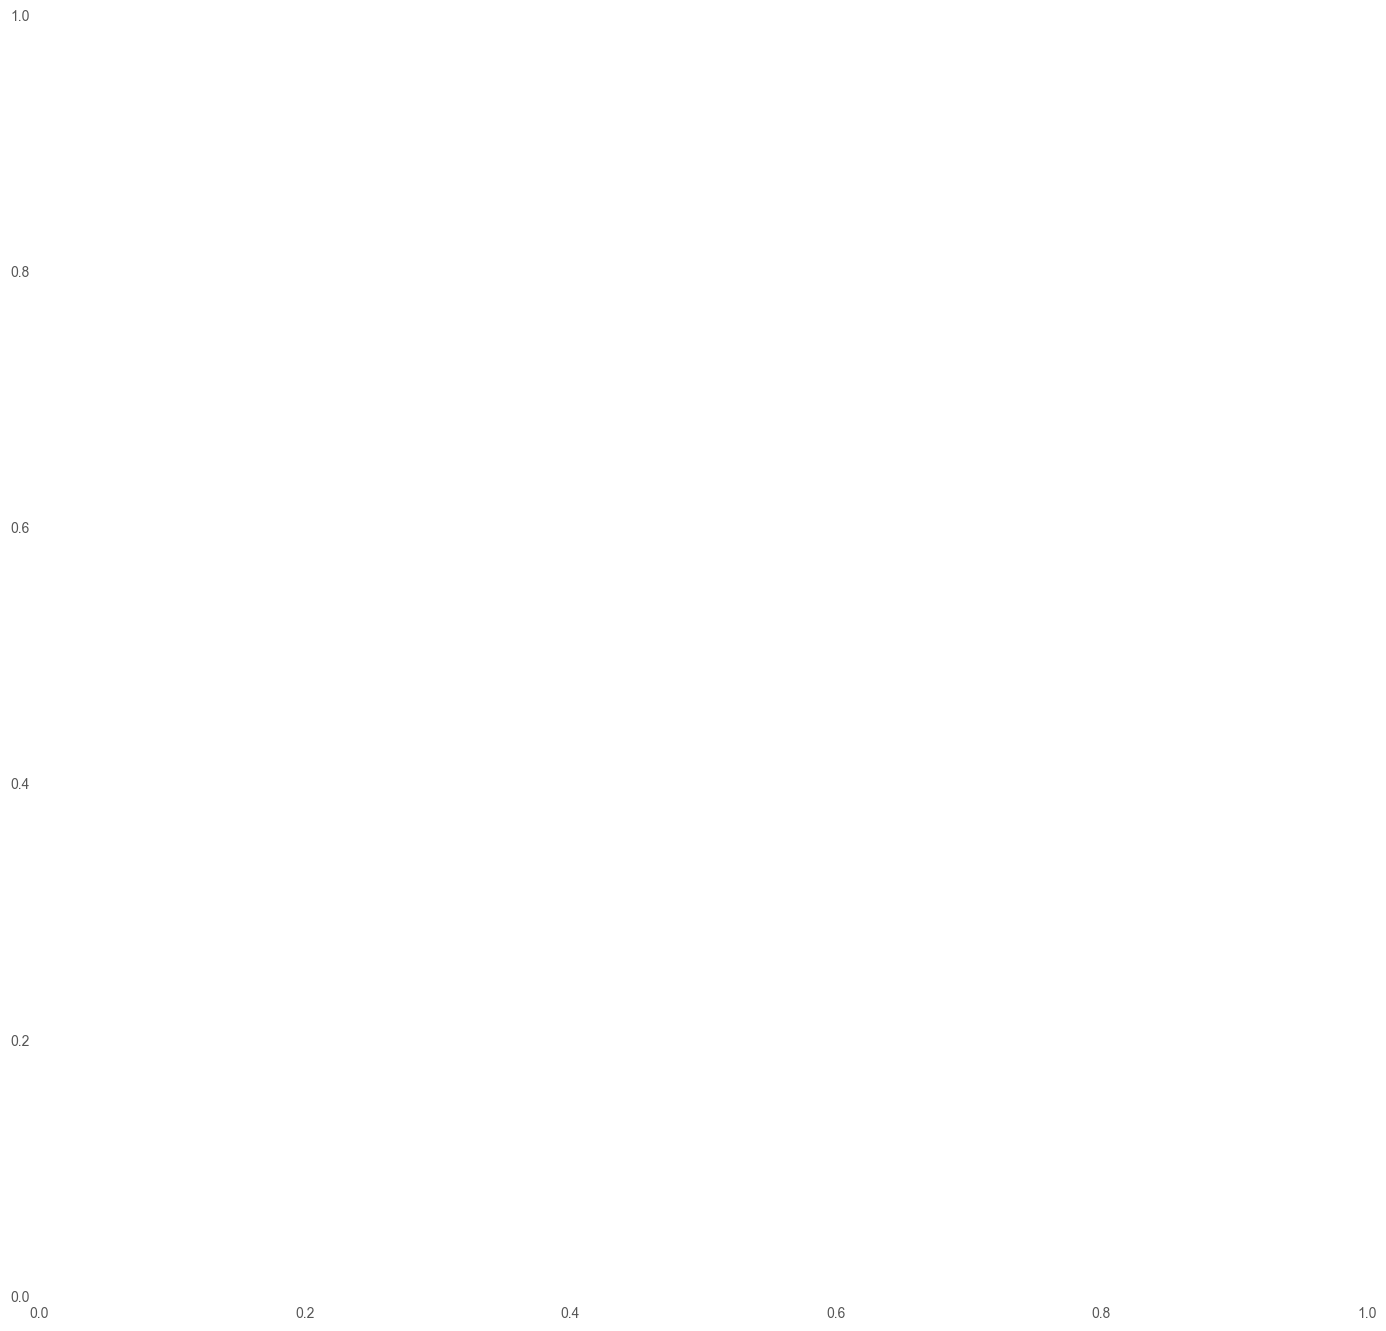

In [89]:
# Draw neighborhoods withpolygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#000000',
    ec='#ffffff', lw=.5, alpha=1,
    zorder=4))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
plt.tight_layout()
fig.set_size_inches(15,15)